This notebook presents different versions of a baseline model, trained on CIFAR-10 dataset. Firstly, we import data. Next, definitions of different models are presented, and lastly, training loop is defined and results for every model are presented.

# Setup

In [ ]:
!git clone https://github.com/Nomow/02456-deep-learning-image-denoising.git
!pip install -U albumentations
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

Cloning into '02456-deep-learning-image-denoising'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 79 (delta 35), reused 58 (delta 16), pack-reused 0
Unpacking objects: 100% (79/79), done.
     |████████████████████████████████| 102 kB 4.4 MB/s 
     |████████████████████████████████| 47.6 MB 2.0 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-wta5h0ec
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-wta5h0ec
     |████████████████████████████████| 58 kB 2.6 MB/s 
     |████████████████████████████████| 376 kB 14.0 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorc

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))
import random

import torch
cuda = torch.cuda.is_available()
from pathlib import Path
import os

import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import transforms, ToTensor
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
import torch.optim as optim

try:
  from data import load_cifar_10_data
  from dataset import Cifar10AutoEncoderDataset
  import utils
except:
  print("Remember to load the python files to colab")

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
# Download CIFAR-10 dataset
!cd ..
!mkdir data
!cd data
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2021-12-26 16:51:46--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  32.2MB/s    in 5.7s    

2021-12-26 16:51:52 (28.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [ ]:
train_imgs, test_imgs = load_cifar_10_data("cifar-10-batches-py")

idx_train = np.random.permutation(np.arange(0,len(train_imgs)))#[:10000]
idx_test = np.random.permutation(np.arange(0,len(test_imgs)))#[:3000]
train_imgs = train_imgs[idx_train]
test_imgs = test_imgs[idx_test]

batch_size = 64

preprocess_transform = A.Compose([
    # transforms.Resize((32, 32)),
    A.Normalize((0.5, ), (0.5, )),
    ToTensorV2()]
)

train_transform = [
    A.Blur(blur_limit=4, always_apply=False, p=0.6),
    A.MultiplicativeNoise(multiplier=(0.7, 1.3), p=0.6),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.4, brightness_by_max=True, always_apply=False, p=0.6),
    A.ISONoise(color_shift=(0.08, 0.15), intensity=(0.2, 0.3), always_apply=False, p=0.6),
    A.RandomToneCurve(scale=0.3, p=0.6)
]
train_transform = A.Compose(train_transform)

train_set = Cifar10AutoEncoderDataset(train_imgs, preprocess_transform, train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = Cifar10AutoEncoderDataset(test_imgs, preprocess_transform, train_transform)#
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
def denormalize(img):
  image = np.swapaxes(np.swapaxes(img.numpy(), 0, 2), 0, 1)
  MEAN = 255 * np.array([0.5, 0.5, 0.5])
  STD = 255 * np.array([0.5, 0.5, 0.5])
  image = ((image * STD)+ MEAN).astype(int)
  return image

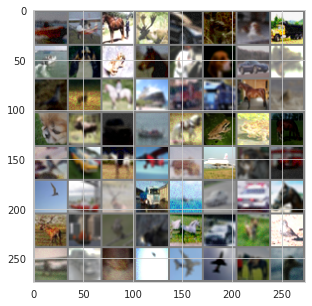

In [ ]:
# Load a batch of images into memory
images, labels = next(iter(train_loader))

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)

# show images
plt.figure(figsize = (10, 5))
imshow(torchvision.utils.make_grid(images))

# Model definitions

First version of a baseline model consists of three dense layers in both encoder and decoder networks, and a relatively small latent space with a dimensionality of 50. ReLU was used as an activation function, no dropout and batch normalization.

In [ ]:
channels, width, height = images.shape[1:4]

# define size variables
num_features = width*height*channels

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units1, hidden_units2,hidden_units3,latent_features=2):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units3, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units3),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        x_hat = torch.tanh(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }

# Choose the shape of the autoencoder
net = AutoEncoder(hidden_units1=1024, hidden_units2=512, hidden_units3=128, latent_features=50)

net = net.to(device)

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=3072, bias=True)
  )
)


Here the only difference between the previous model lies in the addition of batch normalization.

In [ ]:
class AutoEncoderBatchNorm(nn.Module):
    def __init__(self, hidden_units1, hidden_units2,hidden_units3,latent_features=2):
        super(AutoEncoderBatchNorm, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.BatchNorm1d(hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.BatchNorm1d(hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
            nn.BatchNorm1d(hidden_units3),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units3, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units3),
            nn.BatchNorm1d(hidden_units3),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units2),
            nn.BatchNorm1d(hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.BatchNorm1d(hidden_units1),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        x_hat = torch.tanh(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }

In the below model we tried out different activation function and switched from ReLU to LeakyReLU.

In [ ]:
class AutoEncoderLeakyReLU(nn.Module):
    def __init__(self, hidden_units1, hidden_units2,hidden_units3,latent_features=2):
        super(AutoEncoderLeakyReLU, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
            nn.LeakyReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units3, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units3),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units2),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.LeakyReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        x_hat = torch.tanh(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }

Eventually, we arrived at a smaller model as it turned out that smaller complexity gives slightly better results. Also, we removed batch normalization. Two-layer model is presented below.

In [ ]:
class AutoEncoderLeakyReLUShallow(nn.Module):
    def __init__(self, hidden_units1, hidden_units2,latent_features=2):
        super(AutoEncoderLeakyReLUShallow, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.LeakyReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units2, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units2),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        x_hat = torch.tanh(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }

In [ ]:
# Test pass
net = AutoEncoderLeakyReLUShallow(hidden_units1=1024, hidden_units2=512, latent_features=50).to(device)
x, y = next(iter(train_loader))
x = torch.reshape(x, (x.shape[0], -1))
print(f"x.shape = {x.shape}")

outputs = net(x.to(device))
print(f"x_hat.shape = {outputs['x_hat'].shape}")

x.shape = torch.Size([64, 3072])
x_hat.shape = torch.Size([64, 3072])


# Training

For all models trained the size of batch is 64, learning rate is 0.001 and the loss function is a pixel-wise Mean Squared Error loss.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 50
def train(net, optimizer, loss_fun, num_epochs = 50):
  train_loss = []
  valid_loss = []

  for epoch in range(num_epochs):
      batch_loss = []
      avg_loss = 0
      net.train()
      
      for x, y in train_loader:

          x = torch.reshape(x, (x.shape[0], -1))
          y = torch.reshape(y, (y.shape[0], -1))
          
          x = x.to(device)
          y = y.to(device)
          
          outputs = net(x)
          x_hat = outputs['x_hat']

          loss = loss_function(x_hat, y)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          batch_loss.append(loss.item())

          avg_loss += loss.item() / len(x)

      train_loss.append(np.mean(batch_loss))

      # Evaluate, do not propagate gradients
      with torch.no_grad():
          net.eval()
          
          x_val, y_val = next(iter(test_loader))
          
          x_val = torch.reshape(x_val, (x_val.shape[0], -1))
          y_val = torch.reshape(y_val, (y_val.shape[0], -1))
          
          x_val = x_val.to(device)
          y_val = y_val.to(device)
          
          outputs = net(x_val)

          x_hat = outputs['x_hat']
          z = outputs['z'].cpu().numpy() 

          loss = loss_function(x_hat, y_val)

          valid_loss.append(loss.item())

          clear_output(wait=True)
          x_val = x_val.cpu().reshape((batch_size, channels, height, width))
          x_hat = x_hat.cpu().reshape((batch_size, channels, height, width))
          y_val = y_val.cpu().reshape((batch_size, channels, height, width))
          k = 0
          plt.figure(figsize = (15, 7))
          for m in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(denormalize(x_val[m]))
            plt.title('Input')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(denormalize(x_hat[m]))
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(denormalize(y_val[m]))
            plt.title('Target')
            plt.axis('off')
            
            k+=1
          plt.suptitle('%d / %d - train loss: %f, val loss: %f' % (epoch+1, num_epochs, np.mean(batch_loss), loss))
          plt.show()

      fig = plt.figure(figsize=(12,4))
      plt.plot(train_loss, 'b', label = "Tran loss")
      plt.plot(valid_loss, 'orange', label = "Validation loss")
      plt.legend()
      plt.show()
      clear_output(wait=True)

  return train_loss, valid_loss

First model performs very poorly. It can only reconstruct a very blurry shape of the object in the images with contrasting colours.

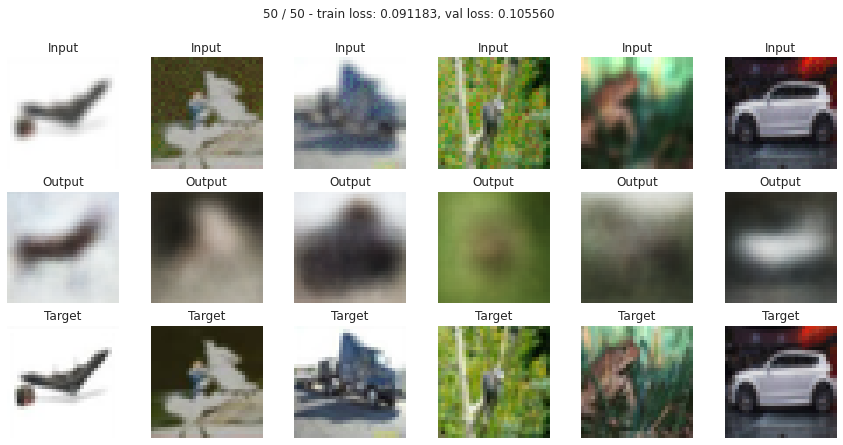

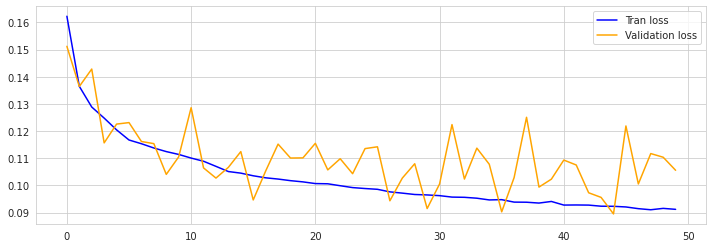

In [ ]:
net = AutoEncoder(hidden_units1=1024, hidden_units2=512, hidden_units3=128, latent_features=100)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_function = nn.MSELoss()

train_loss, valid_loss = train(net, optimizer, loss_function, 50)

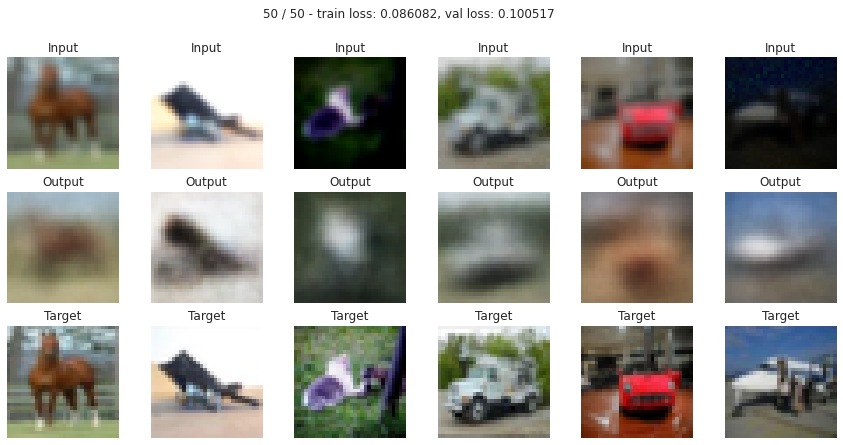

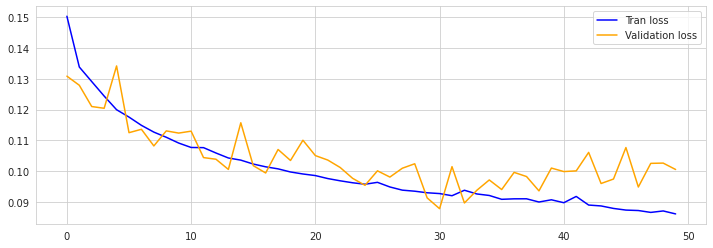

In [ ]:
net = AutoEncoderBatchNorm(hidden_units1=1024, hidden_units2=512, hidden_units3=128, latent_features=100)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_function = nn.MSELoss()

train_loss, valid_loss = train(net, optimizer, loss_function, 50)

The below model performs very similar to the previous ones but we can see a clear sign of overfitting in the learning curve plot. That is why we decided to remove one layer and train the baseline autoencoder with only two dense layers - this time for 100 epochs.

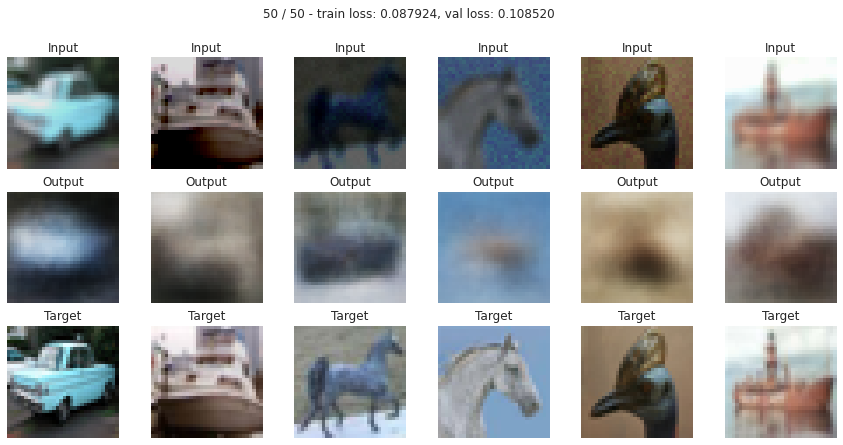

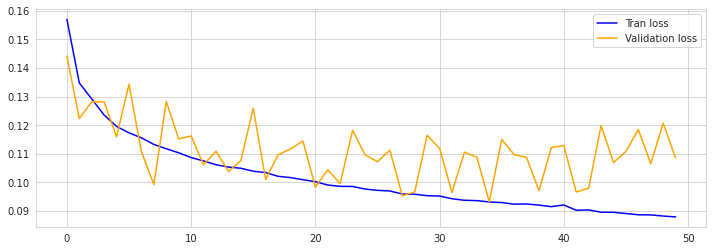

In [ ]:
net = AutoEncoderLeakyReLU(hidden_units1=1024, hidden_units2=512, hidden_units3=128, latent_features=100)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_function = nn.MSELoss()

train_loss, valid_loss = train(net, optimizer, loss_function, 50)

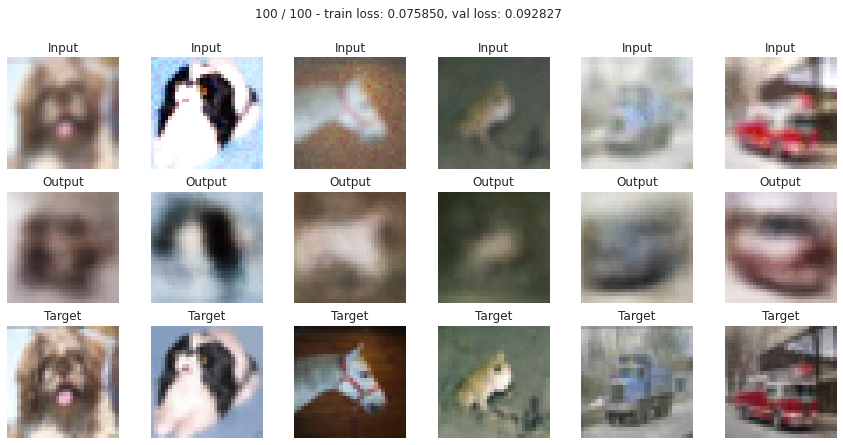

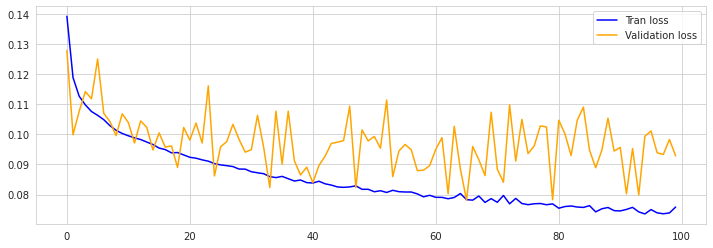

In [ ]:
net = AutoEncoderLeakyReLUShallow(hidden_units1=1024, hidden_units2=512, latent_features=100)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

train_loss, valid_loss = train(net, optimizer, loss_function, num_epochs=100)

The above model with only two hidden layers in encoder/decoder network arrives at the lowest validation loss. After visual inspection and comparison with the results of the previous models, we can see a little bit more details in the output images for the last model. However, the results are still unsatisfactory - the reconstructed images are too blurry and in most cases it is impossible to recognise the object on them.

As expected, using fully connected layers with image data is definitely not the optimal way of approaching this problem as we experience huge loss of information when slicing andstacking the data.